Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

Load dataset and prepare df

In [4]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

Train test split

In [5]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order

In [8]:
stepwise_fit = auto_arima(df[target_column], trace=True, suppress_warnings=True)
best_order = stepwise_fit.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25842.497, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26938.672, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26577.770, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26050.334, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26936.672, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25888.035, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26029.229, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=25790.353, Time=0.72 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=26039.943, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=25820.587, Time=0.99 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=25703.635, Time=0.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=25864.228, Time=0.64 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=25781.631, Time=1.15 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=25752.149, Time=1.16 sec
 ARIMA(2,1,4)(0,0,0

In [9]:
print(best_order)

(5, 1, 5)


Create Model

In [10]:
model = ARIMA(train[target_column], order=best_order)
model = model.fit()
model.summary()

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

Plot the result

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


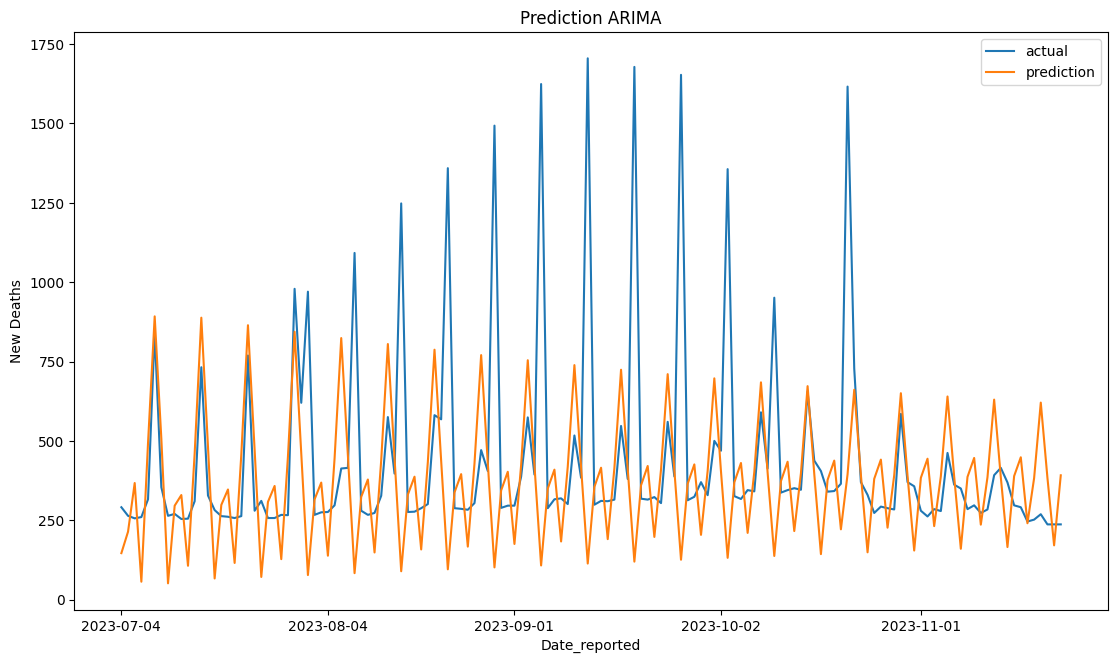

In [6]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels")

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[int(data_length*train_split):], test[target_column].values, label="actual")
ax.plot(dates[int(data_length*train_split):], list(pred), label="prediction")
ax.set_title("Prediction ARIMA")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

RMSE of the result

In [ ]:
non_zero = []
import sys
 
for i in pred:
    if i == 0:
        non_zero.append(i+sys.float_info.min)
    else:
        non_zero.append(i)
print_evaluation_metrics(non_zero, test[target_column])

Evaluation Metrics:
MSE: 156939.47
RMSE: 396.16
MAE: 212.16
MAPE: 39.39
SMAPE: 45.86


In [7]:
store_model(model, "arima")